# Introduction to Convolutional Neural Network (CNN) PART II
> Explains the training of MNIST image classification task by a NN and CNN.
- toc: true 
- badges: true
- comments: true

## Introduction
In the first part, we discussed the fundamentals of a CNN model. We learned how the convolution layer detects various patterns present in the input image. The later convolution layers detect more complex patterns, and so we generally keep on increasing the number of channels as we move to deeper layers. In this post, we will train a NN and CNN on the MNIST dataset and will compare the results.

In [100]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

## MNIST Dataset

Lets load the MNIST dataset in to a dataloader.

(ImageBlock(cls=PILImageBW), CategoryBlock) Tells the input is an image, and output will be one category per input image. There are total 10 categories (0-9). 

get_image_files gets the all image files recursively in the path mentioned.

parent_label labels the image by the name of parent directory the file is present in. All the images are present in subfolder named '0' to '9'.

In [101]:
path = untar_data(URLs.MNIST)

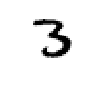

In [71]:
im3 = Image.open(path/'training'/'3'/'12.png')
show_image(im3)

In [103]:
mnist = DataBlock((ImageBlock(cls=PILImageBW), CategoryBlock), 
                  get_items=get_image_files, 
                  get_y=parent_label)

dls = mnist.dataloaders(path/'training')
xb,yb = first(dls.valid)
xb.shape, yb.shape

((64, 1, 28, 28), (64,))

Batch-size is taken as default value 64, the input image is of dimension $1\times 28 \times 28$. 

In [106]:
print(f'Total mini-batches in training dataset are {len(dls.train)}')
print(f'Total mini-batches in validation dataset are {len(dls.valid)}')

Total mini-batches in training dataset are 750
Total mini-batches in validation dataset are 188


In [104]:
print(f'Total classes = {dls.c}')

Total classes = 10


## Architecture

**Convolutional Block**:
I have defined a function *block()* which takes 3 parameters explained as follows:
1. **ni**: This is the number of channels in the input image.
1. **nf**: This is the total number of filters or number of channels in the output image.
1. **stride**: It is the value of stride, default 2, which will be used while convolving filter on the input.

In [107]:
def block(ni, nf, stride=2):
    return ConvLayer(ni, nf, stride=stride)

**CNN Model:** The CNN model I have defined below continuously halves the input grid size by using a stride of two, and so it doubles the number of channels. After the fourth convolutional layer, the output is of size $4\times 4 \times 64$, on it, adaptiveAvgPool2d is applied. It converts the 2x2 grid into the desired shape (passed as 1, therefore it will convert 2x2 into 1x1). The output of this will be of shape $1\times 1\times 64$ which is flattened and put into an fc layer. 

**NN Model** A simple neural network model is also implemented which has 2 layers. 

def get_model():
    basic_cnn = nn.Sequential(
        block(1, 8),
        block(8, 16),
        block(16,32),
        block(32,64),
        nn.AdaptiveAvgPool2d(1),
        Flatten(),
        nn.Linear(64, 10)
    )
    return basic_cnn


def get_nn():
    basic_nn = nn.Sequential(
        nn.Flatten(),            
        nn.Linear(784, 512),
        nn.Linear(512, 10)
    )
    return basic_nn

Let's create a learner that we will use to train both the models.

In [173]:
def get_learner(model):
    return Learner(dls, model, loss_func=nn.CrossEntropyLoss(), metrics=accuracy)


In [174]:
learn = get_learner(get_nn())

## Training

To find the optimal range of learning rate we plot graph of training loss for different lr starting from a small value. The range at which the rate of decrease of loss is sharpest is the range where if lr is taken from the convergence will be faster. We do not choose the lr corresponding to the minimum loss because no/very-slow learning from that point onwards.

SuggestedLRs(lr_min=0.002290867641568184, lr_steep=0.0063095735386013985)

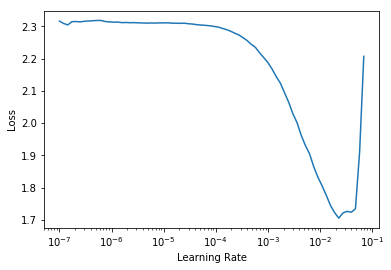

In [175]:
learn.lr_find()

Firstly we will train nn model for 10 epochs, at a max learning rate of 2e-3.

fit_one_cycle() if fits for say 1 epoch, and there are 750 iterations in total, then it starts with a small lr, gradually goes to the max value provided (2e-3 in below code) in first roughly 20% iterations, and then keep on decreasing until the last iteration because later iterations need less lr.

In [167]:
learn.fit_one_cycle(10, 2e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.343918,0.334851,0.903333,00:35
1,0.319538,0.352520,0.902667,00:37
2,0.339889,0.378988,0.897333,00:39
3,0.306681,0.351762,0.905000,00:39
4,0.284653,0.323651,0.910000,00:40
5,0.280786,0.322405,0.911750,00:41
6,0.254253,0.307338,0.919750,00:41
7,0.249282,0.295363,0.922333,00:39
8,0.246942,0.292607,0.924833,00:39
9,0.229630,0.292373,0.924583,00:40


The accuracy achieved by it is 0.925. Now we have seen results from a plain NN, let's try training a CNN and see the results.

In [192]:
learn = get_learner(get_model())

SuggestedLRs(lr_min=0.04365158379077912, lr_steep=0.0831763744354248)

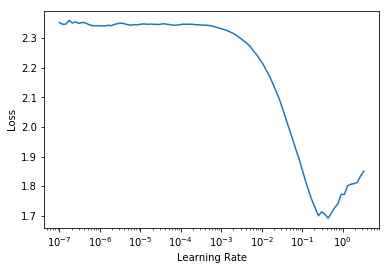

In [187]:
learn.lr_find()

In [193]:
learn.fit_one_cycle(10, 2e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.119381,0.127926,0.961750,00:43
1,0.092528,0.108258,0.966417,00:42
2,0.073737,0.083760,0.974583,00:41
3,0.064387,0.085716,0.973250,00:42
4,0.041789,0.059548,0.983583,00:43
5,0.032186,0.041528,0.987667,00:44
6,0.021864,0.046303,0.987000,00:45
7,0.008966,0.041324,0.988417,00:44
8,0.005580,0.036766,0.989917,00:45
9,0.002051,0.038017,0.990083,00:45


Nice, we have able to get an accuracy of 0.99 with a CNN, which is far better than a simple NN

Clearly, CNN is able to learn patterns of the images better than the plain NN. Also, the dataset is so simple that we are able to get more than 0.99 accuracy with a simple CNN. If the dataset is a complex one that this simple CNN will fail for sure. It will start overfitting, grads flow will be poor, and a lot of other issues. We will get to know more about this in the next and last part, and also we will see far more sophisticated architecture known as **Residual Network (ResNet)**. Thanks.